# 1. Location Set Covering Problem

## 1.1 Setup

In [1]:
# Importing requisite packages
from spopt.locate.coverage import LSCP
from spopt.locate.util import simulated_geo_points

import numpy as np
import geopandas as gpd
import pulp
import spaghetti
from shapely.geometry import Point
import matplotlib.pyplot as plt
import osmnx as ox

C:\Users\imdav\Anaconda3\envs\GeospatialPython\lib\site-packages\spaghetti\network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [136]:
patients = 150 # number of demand points represented as patients
medical_centers = 4 # number of service points represented as medical centers

service_area = 5500 # the max service area in meters; roughly 3.4 mi.

# Setting the random seeds for reproducibility
patient_seed = 54321
medical_centers_seed = 54321

# Setting up the solver
solver = pulp.PULP_CBC_CMD(msg=False, warmStart=True)

<AxesSubplot:>

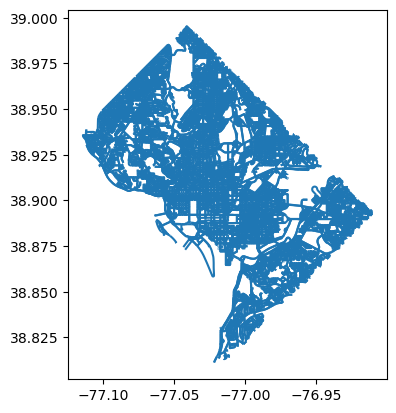

In [2]:
# Extracting the street network for Washington, DC from Open Street Map
G = ox.graph_from_place('Washington, DC', network_type='drive')

# Converting the network to a geopandas datafram of edges/lines and nodes/points
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_edges.reset_index(inplace=True)

# Plotting the edges of the network
gdf_edges.plot()

<AxesSubplot:>

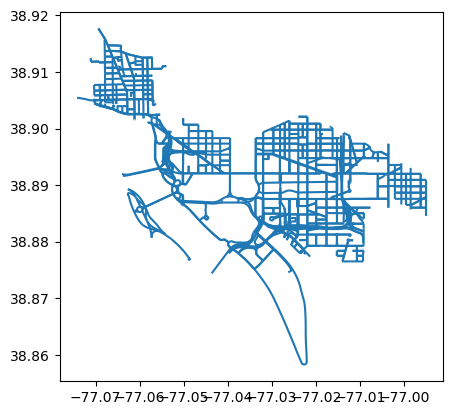

In [4]:
# Extracting the street network for Washington, DC from Open Street Map
G = ox.graph_from_place('Washington, DC', network_type='drive')

# Converting the network to a geopandas datafram of edges/lines and nodes/points
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_edges.reset_index(inplace=True)

# Plotting the edges of the network
gdf_edges.plot()

# Pulling the Washington, DC tracts from the Census Bureau
DC_BGs = gpd.read_file('https://www2.census.gov/geo/tiger/TIGER2022/BG/tl_2022_11_bg.zip', compression='zip')

# Selecting a single tract withing Washington, DC to reduce computation time
DC_BGs_Sel = DC_BGs[DC_BGs['TRACTCE'].isin(['980000','010202','005900','000102','000202',
                                            '010800','005801','005802','010500','005602',
                                           '006600','008200'])]
# Dissolving the blockgroups into the single tract
DC_BGs_Sel_D = DC_BGs_Sel.dissolve()

# Setting the CRS
DC_BGs_Sel_D = DC_BGs_Sel_D.to_crs('EPSG:4326')
#DC_BGs_Sel_D.head()

# Subsetting the network
mask = gdf_edges.within(DC_BGs_Sel_D.loc[0,'geometry'])
gdf_edges_clipped = gdf_edges.loc[mask]
#gdf_edges_clipped.head()

# Plotting the clipped network
gdf_edges_clipped.plot()

In [43]:
# Reducing the number of columns
gdf_edges_clipped = gdf_edges_clipped[['osmid','geometry']]

# Converting to the Albers projection
gdf_edges_clipped_p = gdf_edges_clipped.to_crs(5070)

<AxesSubplot:>

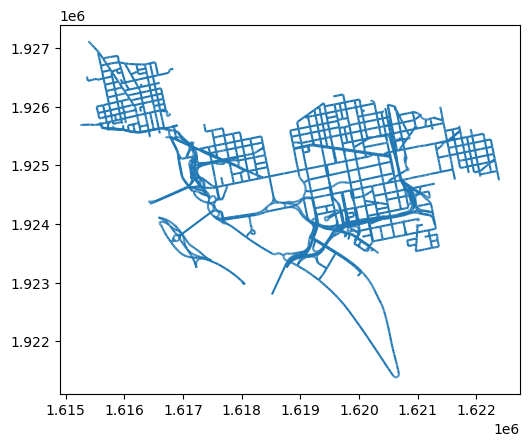

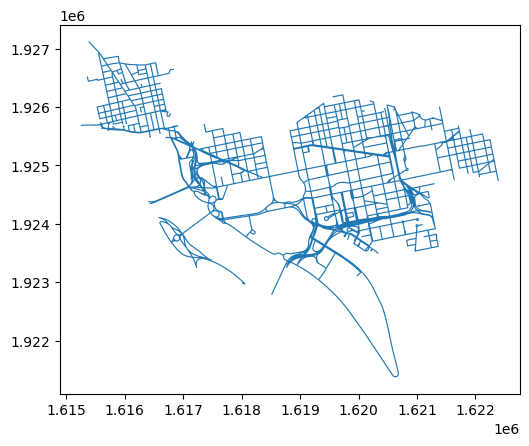

In [154]:
# Converting to a spaghetti network
ntw =  spaghetti.Network(in_data=gdf_edges_clipped_p)

# Converting the spaghetti network into a GeoDataFrame
streets_gpd = spaghetti.element_as_gdf(ntw, arcs=True)

# Plotting the road network
streets_gpd.plot()

# Creating a buffered version of the street network for use later
street_buffer = gpd.GeoDataFrame(
    gpd.GeoSeries(streets_gpd['geometry'].buffer(10).unary_union),
    crs=streets_gpd.crs,
    columns=['geometry']
)
# Plotting the buffered road network
street_buffer.plot()

## 1.2 Simulate points

In [155]:
# Simulating the patient locations
patient_locs = simulated_geo_points(street_buffer, 
                                    needed=patients, 
                                    seed=patient_seed)

# Simulating the medical center locations
medical_center_locs = simulated_geo_points(street_buffer, 
                                    needed=medical_centers, 
                                    seed=medical_centers_seed)

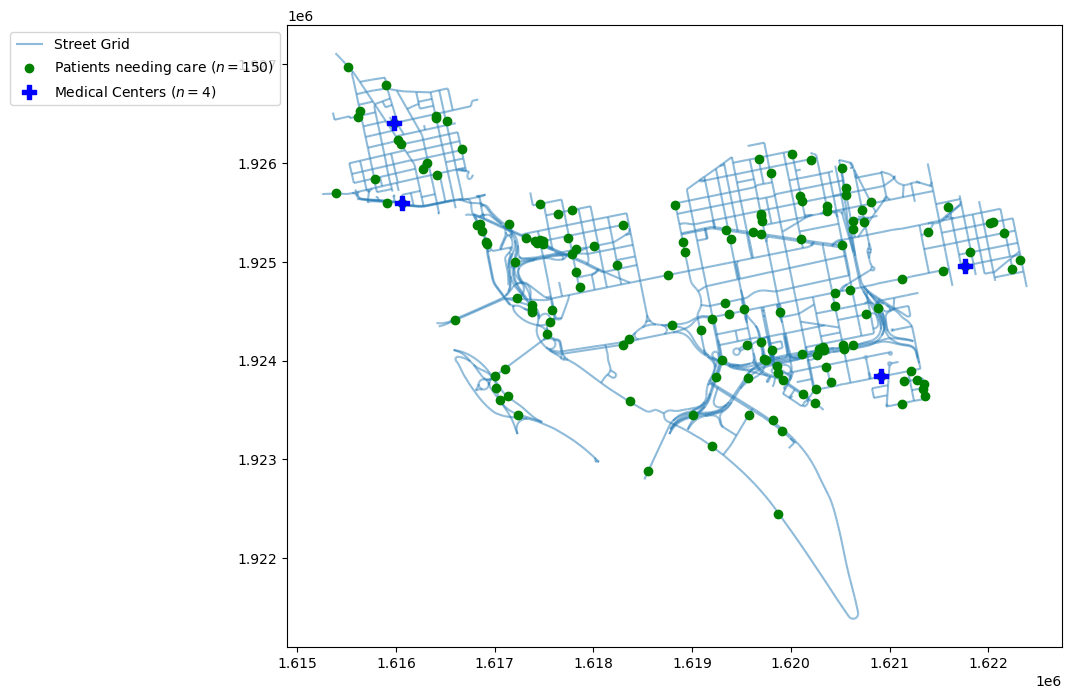

In [157]:
# Plotting the simulated points on the network
fig, ax = plt.subplots(figsize=(10,10))

streets_gpd.plot(ax=ax, alpha=0.5, zorder=1, label='Street Grid')
patient_locs.plot(ax=ax, color='green',zorder=2,label='Patients needing care ($n=$150)')
medical_center_locs.plot(ax=ax, markersize = 100, color='blue',marker="P",zorder=3,label='Medical Centers ($n=$4)')
plt.legend(loc='upper right', bbox_to_anchor=(0,1))

## 1.3 Associate the points to the network

In [140]:
# Snapping the patient locations
ntw.snapobservations(patient_locs,"patients",attribute=True)
patients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="patients", snapped = True
)

# Snapping the medical center locations
ntw.snapobservations(medical_center_locs,"medical_centers",attribute=True)
medical_centers_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="medical_centers", snapped = True
)

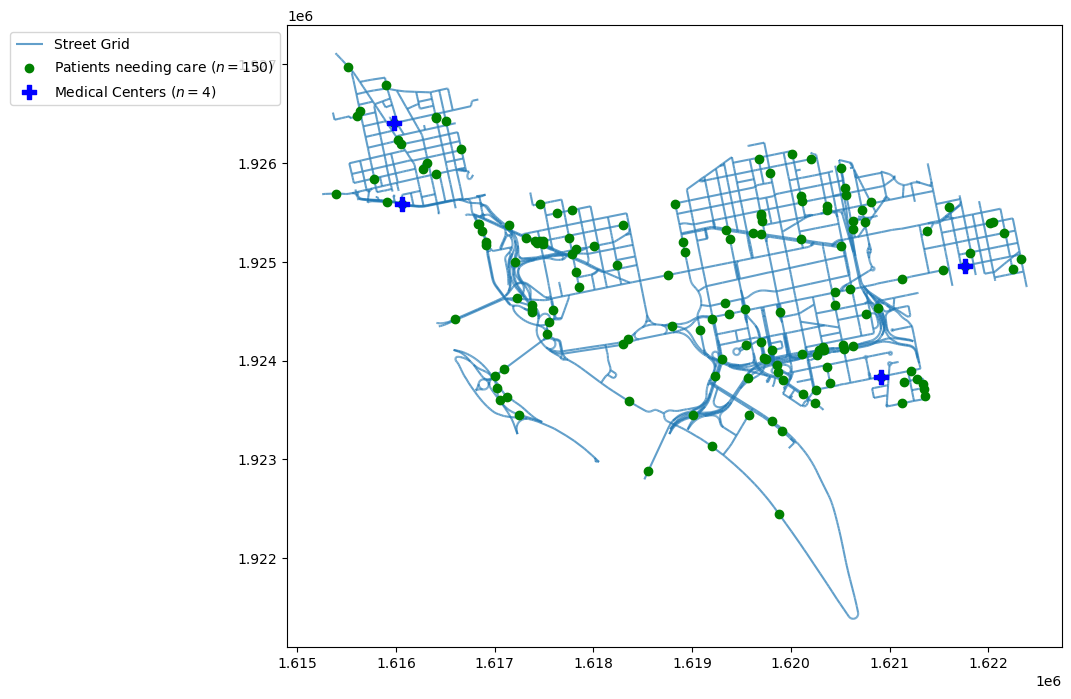

In [141]:
# Plotting the simulated points on the network
fig, ax = plt.subplots(figsize=(10,10))

streets_gpd.plot(ax=ax, alpha=0.5, zorder=1, label='Street Grid')
patients_snapped.plot(ax=ax, color='green',zorder=2,label='Patients needing care ($n=$150)')
medical_centers_snapped.plot(ax=ax, markersize = 100, color='blue',marker="P",zorder=3,label='Medical Centers ($n=$4)')
plt.legend(loc='upper right', bbox_to_anchor=(0,1))

## 1.4 Calculate the cost matrix

In [142]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["patients"],
    destpattern=ntw.pointpatterns["medical_centers"],
)

## 1.5 Solving the problem - Cost Matrix

In [152]:
lscp_from_cost_matrix = LSCP.from_cost_matrix(cost_matrix, service_area)
lscp_from_cost_matrix = lscp_from_cost_matrix.solve(solver)

# Convert to facility client array
lscp_from_cost_matrix.facility_client_array()

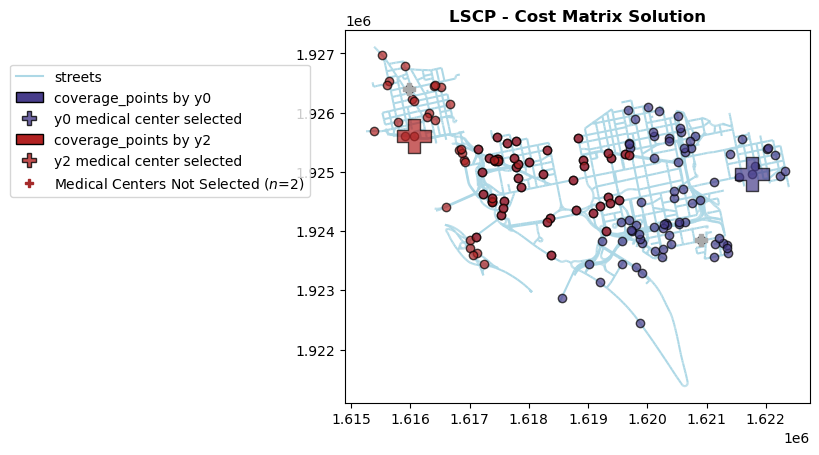

In [153]:
from matplotlib.patches import Patch
import matplotlib.lines as mlines

colors_arr = [
    "darkslateblue",
    "forestgreen",
    "firebrick",
    "peachpuff",
    "saddlebrown",
    "cornflowerblue"    
]

colors_ops = { f"y{i}":colors_arr[i] for i in range(len(colors_arr))}

serviced_points = []
selected_sites = []

for i in range(medical_centers):
    if lscp_from_cost_matrix.fac2cli[i]:

        geom = patient_locs.iloc[lscp_from_cost_matrix.fac2cli[i]]['geometry']
        serviced_points.append(geom)
        selected_sites.append(i)

# Plot the solution
fig, ax = plt.subplots(figsize=(6, 6))
legend_elements = []

# Plot the street network
streets_gpd.plot(ax=ax, alpha=1, color='lightblue', zorder=1)
legend_elements.append(mlines.Line2D(
    [],
    [],
    color='lightblue',
    label='streets',
))

for i in range(len(serviced_points)):
    gdf = gpd.GeoDataFrame(serviced_points[i])

    l = f"y{selected_sites[i]}"

    label = f"coverage_points by y{selected_sites[i]}"
    legend_elements.append(Patch(facecolor=colors_ops[l], edgecolor="k", label=label))

    gdf.plot(ax=ax, zorder=3, alpha=0.7, edgecolor="k", color=colors_ops[l], label=label)
    medical_center_locs.iloc[[selected_sites[i]]].plot(ax=ax,
                            marker="P",
                            markersize=150 * 4.0,
                            alpha=0.7,
                            zorder=4,
                            edgecolor="k",
                            facecolor=colors_ops[l])

    legend_elements.append(mlines.Line2D(
        [],
        [],
        color=colors_ops[l],
        marker="P",
        ms=20 / 2,
        markeredgecolor="k",
        linewidth=0,
        alpha=0.8,
        label=f"y{selected_sites[i]} medical center selected",
    ))
    
# Plot locations of unselected medical centers
mc_not_selected = medical_center_locs.drop(selected_sites)
mc_not_selected.plot(ax=ax, color='darkgrey', marker="P", markersize=80, zorder=3)
legend_elements.append(mlines.Line2D(
    [],
    [],
    color='brown',
    marker="P",
    linewidth=0,
    label=f'Medical Centers Not Selected ($n$={len(mc_not_selected)})'
))


plt.title("LSCP - Cost Matrix Solution", fontweight="bold")
plt.legend(handles = legend_elements, loc='upper right', bbox_to_anchor=(0,1), borderaxespad=2.5)


## 2.0 Routing Problems

In [ ]:
import numpy as np
import pandas as pd
import pulp
import itertools
import gmaps
import googlemaps
import ortools
import matplotlib.pyplot as plt

In [ ]:
API_KEY = 'YOUR API KEY'

In [ ]:
gmaps.configure(api_key=API_KEY)

from googlemaps import Client
client = Client(key=API_KEY)

### 2.1 Traveling Sales Person Problem

In [ ]:
# Setting the random seed for reproducibility
np.random.seed(seed=12345)

# Setting up the problem
customers = 15

# Setting the location of the warehouse
wh_lat = 40.749587
wh_lon = -73.985441

# Creating a synthetic dataset with demand points around the warehouse location
locs = pd.DataFrame({'latitude': np.random.normal(wh_lat, .008, customers),
                              'longitude': np.random.normal(wh_lon, .008, customers)
                    })

# Setting the warehouse as the 0th location
cols = ['latitude','longitude']
wh = pd.DataFrame([[wh_lat,wh_lon]], columns=cols)

# Creating a final dataset
data = wh.append(locs)

# Resetting and dropping the index
data.reset_index(inplace=True)
data.drop(['index'], axis=1, inplace=True)

data.head()   

In [ ]:
# Adding in labels
data.reset_index(inplace=True)
data.rename(columns={'index':'Label'}, inplace=True)
data['Label'] = data['Label'].astype(str)
data.at[0,'Label']='Warehouse'

# Adding in colors
data['colors'] = np.where(data['Label']=='Warehouse', "darkslateblue", "forestgreen")

data.head() 

In [ ]:
import geopandas
import contextily

data_gdf = geopandas.GeoDataFrame(
    data, geometry=geopandas.points_from_xy(data.longitude, data.latitude, crs='EPSG:4326'))

f, ax = plt.subplots(1, figsize=(10, 10))

data_gdf.plot(ax=ax,color=data_gdf['colors'])
        
# Add basemap
contextily.add_basemap(
    ax,
    crs=data_gdf.crs,
    source=contextily.providers.Stamen.Watercolor,
    zoom=16
)

for x, y, label in zip(data_gdf.geometry.x, data_gdf.geometry.y, data_gdf.Label):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

plt.show()

In [ ]:
import sys
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=1000)

# Calculating the distances from Google Maps
distances = np.zeros((len(data_gdf),len(data_gdf)))
data_gdf['coord'] = '0'

for row in range(len(data_gdf)):
    data_gdf.at[row,'coord'] = str(data_gdf.latitude[row]) + "," + str(data_gdf.longitude[row])

for lat in range(len(data_gdf)):
    for lon in range(len(data_gdf)):

        # Call google maps api to calculate distances
        maps_api_result = client.directions(data_gdf['coord'].iloc[lat],
                                            data_gdf['coord'].iloc[lon],
                                            mode='driving')

        # append the distance to the distances df
        distances[lat][lon] = maps_api_result[0]['legs'][0]['distance']['value']   

# Converting array from float to int
dist_int = distances.astype(int)
        
# Display the distance array
print(np.matrix(dist_int))

In [ ]:
# Set the problem
tsp_problem = pulp.LpProblem('tsp_mip', pulp.LpMinimize)

# Defining the problem variables
x = pulp.LpVariable.dicts('x', ((i, j) for i in range(customers+1) for j in range(customers+1)), lowBound = 0, upBound = 1, cat='Binary')

# Tracking the order the points are serviced to prevent subtours
u = pulp.LpVariable.dicts('u', (i for i in range(customers+1)), lowBound = 1, upBound = (customers+1), cat='Integer')

# Establishing the objective function
tsp_problem += pulp.lpSum(dist_int[i][j] * x[i,j] for i in range(customers+1) for j in range (customers+1))

# Setting up the constraints

# Constraint 1
for i in range(customers+1):
    tsp_problem += x[i, i] == 0

# Constraint 2
for i in range(customers+1):
    tsp_problem += pulp.lpSum(x[i, j] for j in range(customers+1)) == 1
    tsp_problem += pulp.lpSum(x[j, i] for j in range(customers+1)) == 1

# Constraint 3 - Eliminates the possibility of a subtour using MTZ formulation
for i in range(customers+1):
    for j in range(customers+1):
        if i != j and (i != 0 and j != 0):
            tsp_problem += u[i] - u[j] <= (customers+1) * (1 - x[i, j]) - 1

In [ ]:
# Solve the TSP 
status = tsp_problem.solve()

status, pulp.LpStatus[status], pulp.value(tsp_problem.objective)

In [ ]:
f, ax = plt.subplots(1, figsize=(10, 10))

data_gdf.plot(ax=ax,color=data_gdf['colors'])
        
# Add basemap
contextily.add_basemap(
    ax,
    crs=data_gdf.crs,
    source=contextily.providers.Stamen.Watercolor,
    zoom=16
)

for lon, lat, label in zip(data_gdf.geometry.x, data_gdf.geometry.y, data_gdf.Label):
    ax.annotate(label, xy=(lon, lat), xytext=(3, 3), textcoords="offset points")
    
# Plot the optimal route between stops
routes = [(i, j) for i in range(customers+1) for j in range(customers+1) if pulp.value(x[i, j]) == 1]

arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='darkblue')

for i, j in routes:
    ax.annotate('', xy=[data_gdf.iloc[j].geometry.x, data_gdf.iloc[j].geometry.y], xytext=[data_gdf.iloc[i].geometry.x, data_gdf.iloc[i].geometry.y], arrowprops=arrowprops)
    

plt.show()

### 2.2 Vehicle Routing Problem (VRP)

In [ ]:
# Additional Problem Parameters
vehicles = 1

# Adding simulated demand to the dataset
demand = np.random.randint(2,12,customers).tolist()
demand = [0] + demand
data_gdf['customer_demand'] = demand

data_gdf.head()                          

In [ ]:
# Setting up the PuLP Solver
for vehicles in range(1, vehicles+1):
    
    # Linear Programming Problem
    lp_problem = pulp.LpProblem("VRP", pulp.LpMinimize)
    
    # Defining problem variables which are binary
    x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None 
           for k in range(vehicles)] 
          for j in range(customers+1)] 
         for i in range(customers+1)]
    
    # Setting the objective function
    lp_problem += pulp.lpSum(dist_int[i][j] * x[i][j][k] if i != j else 0
                             for k in range(vehicles)
                             for j in range(customers+1)
                             for i in range(customers+1))
    
    # Adding in the constraints
    for j in range (1, customers+1):
        lp_problem += pulp.lpSum(x[i][j][k] if i != j else 0 for i in range(customers+1) for k in range(vehicles)) == 1
    
    for k in range(vehicles):
        lp_problem += pulp.lpSum(x[0][j][k] for j in range(1, customers+1)) == 1
        lp_problem += pulp.lpSum(x[i][0][k] for i in range(1, customers+1)) == 1
    
    for k in range(vehicles):
        for j in range(customers+1):
            lp_problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                  for i in range(customers+1)) - pulp.lpSum(x[j][i][k] for i in range(customers+1)) == 0
    
    # Adding additional constraint to prevent subtours. We'll use DFJ formulation here.
    subtours = []
    for i in range(2, customers+1):
        subtours += itertools.combinations(range(1, customers+1), i)
    for s in subtours:
        lp_problem += pulp.lpSum(x[i][j][k] if i != j else 0 for i, j in itertools.permutations(s,2) for k in range(vehicles)) <= len(s) -1

    if lp_problem.solve() == 1:
        print('# Required Vehicles:',vehicles)
        print('Distance:',pulp.value(lp_problem.objective))
        break

In [ ]:
f, ax = plt.subplots(1, figsize=(10, 10))

data_gdf.plot(ax=ax,color=data_gdf['colors'])
        
# Add basemap
contextily.add_basemap(
    ax,
    crs=data_gdf.crs,
    source=contextily.providers.Stamen.Watercolor,
    zoom=16
)

for lon, lat, label in zip(data_gdf.geometry.x, data_gdf.geometry.y, data_gdf.Label):
    ax.annotate(label, xy=(lon, lat), xytext=(3, 3), textcoords="offset points")


# Plot the optimal route between stops
routes = [(k, i, j) for k in range(vehicles) for i in range(customers+1) for j in range(customers+1) if i != j and pulp.value(x[i][j][k]) == 1]

arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='darkblue')

for k, i, j in routes:
    ax.annotate('', xy=[data_gdf.iloc[j].geometry.x, data_gdf.iloc[j].geometry.y], xytext=[data_gdf.iloc[i].geometry.x, data_gdf.iloc[i].geometry.y], arrowprops=arrowprops)

plt.show()

In [ ]:
# Count the total amount of demand
data_gdf['customer_demand'].sum()

### 2.3 Capacitated Vehicle Routing Problem (CVRP)

In [ ]:
# Additional Problem Parameters
vehicles = 5
capacity = 40                 

In [ ]:
# Setting up the PuLP Solver

for vehicles in range(1, vehicles+1):
    
    # Linear Programming Problem
    lp_problem = pulp.LpProblem("CVRP", pulp.LpMinimize)
    
    # Defining problem variables which are binary
    x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None 
           for k in range(vehicles)] 
          for j in range(customers+1)] 
         for i in range(customers+1)]
    
    # Setting the objective function
    lp_problem += pulp.lpSum(dist_int[i][j] * x[i][j][k] if i != j else 0
                             for k in range(vehicles)
                             for j in range(customers+1)
                             for i in range(customers+1))
    
    # Adding in the constraints
    for j in range (1, customers+1):
        lp_problem += pulp.lpSum(x[i][j][k] if i != j else 0 for i in range(customers+1) for k in range(vehicles)) == 1
    
    for k in range(vehicles):
        lp_problem += pulp.lpSum(x[0][j][k] for j in range(1, customers+1)) == 1
        lp_problem += pulp.lpSum(x[i][0][k] for i in range(1, customers+1)) == 1
    
    for k in range(vehicles):
        for j in range(customers+1):
            lp_problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                 for i in range(customers+1)) - pulp.lpSum(x[j][i][k] for i in range(customers+1)) == 0
    
    # Adding in the capacity constraint
    for k in range(vehicles):
        lp_problem += pulp.lpSum(data.customer_demand[j] * x[i][j][k] if i != j else 0 for i in range(customers+1) for j in range (1,customers+1)) <= capacity
    
    # Adding additional constraint to prevent subtours. We'll use DFJ formulation here.
    subtours = []
    for i in range(2, customers+1):
        subtours += itertools.combinations(range(1, customers+1), i)
    for s in subtours:
        lp_problem += pulp.lpSum(x[i][j][k] if i != j else 0 for i, j in itertools.permutations(s,2) for k in range(vehicles)) <= len(s) -1

    if lp_problem.solve() == 1:
        print('# Required Vehicles:',vehicles)
        print('Distance:',pulp.value(lp_problem.objective))
        break


In [ ]:
f, ax = plt.subplots(1, figsize=(10, 10))

data_gdf.plot(ax=ax,color=data_gdf['colors'])
        
# Add basemap
contextily.add_basemap(
    ax,
    crs=data_gdf.crs,
    source=contextily.providers.Stamen.Watercolor,
    zoom=16
)

for lon, lat, label in zip(data_gdf.geometry.x, data_gdf.geometry.y, data_gdf.Label):
    ax.annotate(label, xy=(lon, lat), xytext=(3, 3), textcoords="offset points")

# Plot the optimal route between stops
routes = [(k, i, j) for k in range(vehicles) for i in range(customers+1) for j in range(customers+1) if i != j and pulp.value(x[i][j][k]) == 1]

for k, i, j in routes:
    if k == 0:
        arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='blue')
        ax.annotate('', xy=[data_gdf.iloc[j].geometry.x, data_gdf.iloc[j].geometry.y], xytext=[data_gdf.iloc[i].geometry.x, data_gdf.iloc[i].geometry.y], arrowprops=arrowprops)
    elif k==1:
        arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='purple')
        ax.annotate('', xy=[data_gdf.iloc[j].geometry.x, data_gdf.iloc[j].geometry.y], xytext=[data_gdf.iloc[i].geometry.x, data_gdf.iloc[i].geometry.y], arrowprops=arrowprops)
    else:
        arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='black')
        ax.annotate('', xy=[data_gdf.iloc[j].geometry.x, data_gdf.iloc[j].geometry.y], xytext=[data_gdf.iloc[i].geometry.x, data_gdf.iloc[i].geometry.y], arrowprops=arrowprops)
         
# Display the plot       
plt.show()